In [1]:
%%time
import pyfesom2 as pf
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import cmocean
import matplotlib.colors as colors
import matplotlib.dates as mdates
import pandas as pd
import gc
import shutil
import os
import matplotlib.tri as mtri
import dask

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cartnn
from scipy.interpolate import NearestNDInterpolator

from string import ascii_lowercase as abc

osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.
CPU times: user 4.03 s, sys: 2.96 s, total: 7 s
Wall time: 8.47 s


In [2]:
deps=[[0,50],[100,300]]
yearmin = 2015

In [3]:
calc = True
overwrite = True
plot = True
savefig = True

In [4]:
res = 'ultra'
vertical_split = 1
time_split = 12

In [5]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title


In [6]:
#paths 
data_path = '/p/scratch/chhb19/mueller29/AO_40_nopc/'
mesh_path = '/p/project/chhb19/meshes/AO_40/'
plot_path  = '/p/home/jusers/mueller29/juwels/EPICA/plots/figures_paper/'
out_path = '/p/scratch/chhb19/mueller29/maps/'

In [7]:
def discrete_cmap(N, base_cmap=None):
    from matplotlib.colors import LinearSegmentedColormap
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    #return base.from_list(cmap_name, color_list, N)
    return LinearSegmentedColormap.from_list(cmap_name, color_list, N)

In [8]:
mesh = pf.load_mesh(mesh_path)
elements = mesh.elem.astype("int32")
lons = mesh.x2
lats = mesh.y2
points = np.vstack((lons, lats)).T
d = lons[elements].max(axis=1) - lons[elements].min(axis=1)
no_cyclic_elem = np.argwhere(d < 100).ravel()
triang = mtri.Triangulation(lons, lats, elements[no_cyclic_elem])
depth = -xr.open_dataset((mesh_path+'fesom.mesh.diag.nc'))['zbar_n_bottom'].astype('float32')


/p/project/chhb19/meshes/AO_40/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /p/project/chhb19/meshes/AO_40/pickle_mesh_py3_fesom2


In [9]:
if calc:
    t = xr.open_mfdataset(out_path+'KE.fesom.0_50_mean.*.nc').time #time vector
    
    alpha = -90
    beta = 90
    gamma = 90
    # load mesh and rotate to equator
    mesh = pf.load_mesh(mesh_path)
    elements = mesh.elem.astype("int32")
    lons = mesh.x2
    lats = mesh.y2
    # region
    left = -180
    right = 180
    south = 70
    north = 90
    

    lons_rot, lats_rot = pf.ut.scalar_g2r(alpha, beta, gamma, lons,lats)
    d = lons_rot[elements].max(axis=1) - lons_rot[elements].min(axis=1)
    no_cyclic_elem = np.argwhere(d < 100).ravel()
    points_rot = np.vstack((lons_rot, lats_rot)).T
    triang = mtri.Triangulation(lons_rot, lats_rot, elements[no_cyclic_elem])



    # regular grid at equator for interpolation
    if res == 'ultra':
        dx = 0.01
        dy = 0.01
    elif res == 'high':
        dx = 0.05
        dy = 0.05    
    elif res == 'low':    
        dx = 0.1
        dy = 0.1

    nx2 = (
        north - south + dx
    )  # just to make sure the grid isn't square (makes it easier to keep track of dimensions)
    ny2 = north - south
    lon_reg = np.arange(-nx2, nx2, dx)
    lat_reg = np.arange(-ny2, ny2, dy)
    xx_eq, yy_eq = np.meshgrid(lon_reg, lat_reg)
    xx_eq = xx_eq.T
    yy_eq = yy_eq.T
    xx_pol, yy_pol = pf.ut.scalar_r2g(
        alpha, beta, gamma, xx_eq, yy_eq
    ) 

    tri = triang.get_trifinder()
    
    
    
    for dep in deps:
        top = dep[0]
        bottom = dep[1]
        eke_file = out_path+'eke_gridded_'+str(top)+'_'+str(bottom)+'average_'+res+'.npz'
        tke_file = out_path+'tke_gridded_'+str(top)+'_'+str(bottom)+'average_'+res+'.npz'
        wpbp_file = out_path+'ice_gridded_'+str(top)+'_'+str(bottom)+'average_'+res+'.npz'
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):            
            EKE = xr.open_mfdataset(out_path+'KE.fesom.'+str(top)+'_'+str(bottom)+'_mean.*.nc')['EKE'].isel(time=t.dt.year>=yearmin).mean(dim='time')
            EKE[depth<bottom]=np.nan
            eke_grid = mtri.LinearTriInterpolator(triang, EKE, trifinder=tri)(xx_eq, yy_eq)
            TKE = xr.open_mfdataset(out_path+'KE.fesom.'+str(top)+'_'+str(bottom)+'_mean.*.nc')['TKE'].isel(time=t.dt.year>=yearmin).mean(dim='time')
            TKE[depth<bottom]=np.nan
            tke_grid = mtri.LinearTriInterpolator(triang, TKE, trifinder=tri)(xx_eq, yy_eq)
            wpbp = xr.open_mfdataset(out_path+'wpbp.fesom.'+str(top)+'_'+str(bottom)+'_mean.*.nc')['ECR'].isel(time=t.dt.year>=yearmin).mean(dim='time')
            wpbp[depth<bottom]=np.nan
            wpbp_grid = mtri.LinearTriInterpolator(triang, wpbp, trifinder=tri)(xx_eq, yy_eq)
        #save stuff
        np.savez_compressed(eke_file,xx_pol=xx_pol, yy_pol=yy_pol,eke_grid=eke_grid)
        np.savez_compressed(tke_file,xx_pol=xx_pol, yy_pol=yy_pol,tke_grid=tke_grid)
        np.savez_compressed(wpbp_file,xx_pol=xx_pol, yy_pol=yy_pol,wpbp_grid=wpbp_grid)

/p/project/chhb19/meshes/AO_40/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /p/project/chhb19/meshes/AO_40/pickle_mesh_py3_fesom2


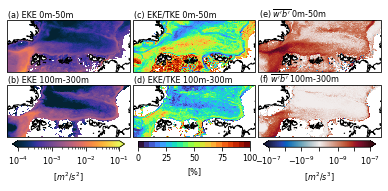

In [10]:
dd = 1 # for fast plotting, plot only every d points
abc_lab='acebdf'
%matplotlib inline
cm2in = 1/2.54  # centimeters in inches
figsize=(19*cm2in,11.5*cm2in)

fig, axs = plt.subplots(
            2,
            3,
            subplot_kw=dict(projection=ccrs.RotatedPole(pole_longitude=240.0, pole_latitude=45.0, central_rotated_longitude=0.0)),
            figsize=figsize,
        )

d_str=['0m-50m','100m-300m']
w_str=['EKE','EKE/TKE','$\overline{w^{\prime} b^{\prime}}$']
spp=0
for d in range(len(deps)):
    top = deps[d][0]
    bottom = deps[d][1]
    eke_file = out_path+'eke_gridded_'+str(top)+'_'+str(bottom)+'average_'+res+'.npz'
    tke_file = out_path+'tke_gridded_'+str(top)+'_'+str(bottom)+'average_'+res+'.npz'
    wpbp_file = out_path+'ice_gridded_'+str(top)+'_'+str(bottom)+'average_'+res+'.npz'
    eke_stuff = np.load(eke_file)
    xx_pol = eke_stuff['xx_pol']
    yy_pol = eke_stuff['yy_pol']
    eke_grid = eke_stuff['eke_grid']  
    tke_grid = np.load(tke_file)['tke_grid']  
    wpbp_grid = np.load(wpbp_file)['wpbp_grid']  
    tke_grid[tke_grid==0]=np.nan
    frac = eke_grid/tke_grid
    

    
    image_eke = axs[d][0].pcolormesh(xx_pol[::dd,::dd],yy_pol[::dd,::dd],eke_grid[::dd,::dd],cmap = cmocean.cm.thermal, norm=colors.LogNorm(vmin=1e-4, vmax=1e-1), shading='auto',transform=ccrs.PlateCarree())
    image_frac = axs[d][1].pcolormesh(xx_pol[::dd,::dd],yy_pol[::dd,::dd],100*frac[::dd,::dd],cmap = discrete_cmap(20,'turbo'),vmin=0, vmax=100, shading='auto',transform=ccrs.PlateCarree())
    image_wpbp = axs[d][2].pcolormesh(xx_pol[::dd,::dd],yy_pol[::dd,::dd],wpbp_grid[::dd,::dd],cmap = cmocean.cm.balance, norm=colors.SymLogNorm(linthresh=1e-7/100, linscale=1, vmin=-1e-7, vmax=1e-7, base=10),shading='auto',transform=ccrs.PlateCarree())
    
    
    norm=colors.TwoSlopeNorm(vcenter=0., vmin=-1e-9, vmax=4e-9)

    for ii in range(len(axs[d])):
        ax = axs[d][ii]        
        ax.set_extent([-50,170,77,90], crs=ccrs.PlateCarree())
        #ax.background_img(name='BM', resolution='high',extent=[-180,180,65,90],cache=True)
        ax.coastlines(resolution='50m')
        ax.text(.01, 1.04, '('+abc_lab[spp]+') '+w_str[ii]+' '+d_str[d],zorder=100, transform=ax.transAxes, size=SMALL_SIZE)
        spp += 1

            
        
# #manually adjust positions of subplots for tight layout    
chartBox_top=axs[0][0].get_position()
chartBox_bot=axs[1][0].get_position()
            
for ii in range(3):
    chartBox = axs[1][ii].get_position()
    axs[1][ii].set_position([chartBox.x0, 
                  chartBox_top.y0-chartBox_bot.height-0.04, #adjust vertical position of lower plots
                  chartBox.width,
                  chartBox.height])

for d in range(len(deps)):   
    for ii in range(3):
        chartBox = axs[d][ii].get_position()
        axs[d][ii].set_position([chartBox_top.x0+ii*(chartBox.width+.005), #adjust horizontal position of the two right plots
                      chartBox.y0,
                      chartBox.width,
                      chartBox.height])

#add colorbars      
chartBox1 = axs[1,0].get_position()
width = chartBox1.width-0.02
cbar_ax = fig.add_axes([chartBox1.x0+0.01, chartBox1.y0-.03, width, 0.02])
cb_eke=fig.colorbar(image_eke,cax=cbar_ax,orientation="horizontal",extend='both')
cb_eke.set_label(r'[$m^2/s^2$]', size=SMALL_SIZE)

chartBox1 = axs[1,1].get_position()
width = chartBox1.width-0.02
cbar_ax = fig.add_axes([chartBox1.x0+0.01, chartBox1.y0-.03, width, 0.02])
cb_frac=fig.colorbar(image_frac,cax=cbar_ax,orientation="horizontal",extend='neither')
cb_frac.set_label(r'[%]', size=SMALL_SIZE)

chartBox1 = axs[1,2].get_position()
width = chartBox1.width-0.02
cbar_ax = fig.add_axes([chartBox1.x0+0.01, chartBox1.y0-.03, width, 0.02])
cb_wpbp=fig.colorbar(image_wpbp,cax=cbar_ax,orientation="horizontal",extend='both')
cb_wpbp.set_label(r'[$m^2/s^3$]', size=SMALL_SIZE)
for label in cb_wpbp.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)


# cb_eke = plt.colorbar(image_eke, orientation='horizontal', ax=axs[:,0], shrink=0.85, extend='both')
# cb_eke.set_label(r'[$m^2/s^2$]', size=SMALL_SIZE)

# cb_frac = plt.colorbar(image_frac, orientation='horizontal', ax=axs[:,1], shrink=0.85, extend='neither')
# cb_frac.set_label(r'[%]', size=SMALL_SIZE)

# cb_wpbp = plt.colorbar(image_wpbp, orientation='horizontal', ax=axs[:,2], shrink=0.85, extend='both')
# cb_wpbp.set_label(r'[$m^2/s^3$]', size=SMALL_SIZE)
# for label in cb_wpbp.ax.yaxis.get_ticklabels()[::2]:
#     label.set_visible(False)


if savefig:
   fig.savefig(plot_path + 'F2_average_maps_landscape.png', dpi=400, format='png',bbox_inches='tight',pad_inches=0)

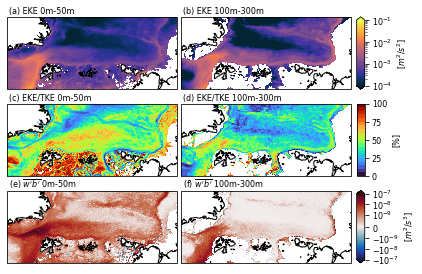

In [11]:
dd = 1 # for fast plotting, plot only every d points
abc_lab='acebdf'
%matplotlib inline
cm2in = 1/2.54  # centimeters in inches
figsize=(19*cm2in,11.5*cm2in)

fig, axs = plt.subplots(
            3,
            2,
            subplot_kw=dict(projection=ccrs.RotatedPole(pole_longitude=240.0, pole_latitude=45.0, central_rotated_longitude=0.0)),
            figsize=figsize,
        )

d_str=['0m-50m','100m-300m']
w_str=['EKE','EKE/TKE','$\overline{w^{\prime} b^{\prime}}$']
spp=0
for d in range(len(deps)):
    top = deps[d][0]
    bottom = deps[d][1]
    eke_file = out_path+'eke_gridded_'+str(top)+'_'+str(bottom)+'average_'+res+'.npz'
    tke_file = out_path+'tke_gridded_'+str(top)+'_'+str(bottom)+'average_'+res+'.npz'
    wpbp_file = out_path+'ice_gridded_'+str(top)+'_'+str(bottom)+'average_'+res+'.npz'
    eke_stuff = np.load(eke_file)
    xx_pol = eke_stuff['xx_pol']
    yy_pol = eke_stuff['yy_pol']
    eke_grid = eke_stuff['eke_grid']  
    tke_grid = np.load(tke_file)['tke_grid']  
    wpbp_grid = np.load(wpbp_file)['wpbp_grid']  
    tke_grid[tke_grid==0]=np.nan
    frac = eke_grid/tke_grid
    

    
    image_eke = axs[0][d].pcolormesh(xx_pol[::dd,::dd],yy_pol[::dd,::dd],eke_grid[::dd,::dd],cmap = cmocean.cm.thermal, norm=colors.LogNorm(vmin=1e-4, vmax=1e-1), shading='auto',transform=ccrs.PlateCarree())
    image_frac = axs[1][d].pcolormesh(xx_pol[::dd,::dd],yy_pol[::dd,::dd],100*frac[::dd,::dd],cmap = discrete_cmap(20,'turbo'),vmin=0, vmax=100, shading='auto',transform=ccrs.PlateCarree())
    image_wpbp = axs[2][d].pcolormesh(xx_pol[::dd,::dd],yy_pol[::dd,::dd],wpbp_grid[::dd,::dd],cmap = cmocean.cm.balance, norm=colors.SymLogNorm(linthresh=1e-7/100, linscale=1, vmin=-1e-7, vmax=1e-7, base=10),shading='auto',transform=ccrs.PlateCarree())
    
    
    norm=colors.TwoSlopeNorm(vcenter=0., vmin=-1e-9, vmax=4e-9)

    for ii in range(3):
        ax = axs[ii][d]        
        ax.set_extent([-50,170,77,90], crs=ccrs.PlateCarree())
        #ax.background_img(name='BM', resolution='high',extent=[-180,180,65,90],cache=True)
        ax.coastlines(resolution='50m')
        ax.text(.01, 1.04, '('+abc_lab[spp]+') '+w_str[ii]+' '+d_str[d],zorder=100, transform=ax.transAxes, size=SMALL_SIZE)
        spp += 1

            
        
# #manually adjust positions of subplots for tight layout    
        
for ii in range(3):
    chartBox = axs[ii][1].get_position()
    axs[ii][1].set_position([chartBox.x0-0.1,  #adjust horizontal position of right plots
                  chartBox.y0,
                  chartBox.width,
                  chartBox.height])


#add colorbars      
chartBox1 = axs[0,1].get_position()
cbar_ax = fig.add_axes([chartBox1.x0+chartBox1.width+0.01, chartBox1.y0, 0.015, chartBox1.height])
cb_eke=fig.colorbar(image_eke,cax=cbar_ax,orientation="vertical",extend='both')
cb_eke.set_label(r'[$m^2/s^2$]', size=SMALL_SIZE)



chartBox1 = axs[1,1].get_position()
cbar_ax = fig.add_axes([chartBox1.x0+chartBox1.width+0.01, chartBox1.y0, 0.015, chartBox1.height])
cb_frac=fig.colorbar(image_frac,cax=cbar_ax,orientation="vertical",extend='neither')
cb_frac.set_label(r'[%]', size=SMALL_SIZE)

chartBox1 = axs[2,1].get_position()
cbar_ax = fig.add_axes([chartBox1.x0+chartBox1.width+0.01, chartBox1.y0, 0.015, chartBox1.height])
cb_wpbp=fig.colorbar(image_wpbp,cax=cbar_ax,orientation="vertical",extend='both')
cb_wpbp.set_label(r'[$m^2/s^3$]', size=SMALL_SIZE)
for label in cb_wpbp.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)


if savefig:
  fig.savefig(plot_path + 'F2_average_maps_portrait.png', dpi=400, format='png',bbox_inches='tight',pad_inches=0)

In [12]:
o_path = '/p/project/chhb19/mueller29/data_EKE_paper/'

for d in range(len(deps)):
    top = deps[d][0]
    bottom = deps[d][1]
    eke_file = out_path+'eke_gridded_'+str(top)+'_'+str(bottom)+'average_'+res+'.npz'
    tke_file = out_path+'tke_gridded_'+str(top)+'_'+str(bottom)+'average_'+res+'.npz'
    wpbp_file = out_path+'ice_gridded_'+str(top)+'_'+str(bottom)+'average_'+res+'.npz'
    eke_stuff = np.load(eke_file)
    xx_pol = eke_stuff['xx_pol']
    yy_pol = eke_stuff['yy_pol']
    eke_grid = eke_stuff['eke_grid']  
    tke_grid = np.load(tke_file)['tke_grid']  
    wpbp_grid = np.load(wpbp_file)['wpbp_grid']  
    
    
    dout = xr.Dataset(
        data_vars=dict(
            EKE=(['x', 'y'], eke_grid),
        ),
        coords=dict(
            XX=(['x', 'y'], xx_pol),
            YY=(['x', 'y'], yy_pol),
        ),
        attrs=dict(
            description="eddy kinetic energy",
            units="m2/s2",
        ),
    )     
    dout.to_netcdf((o_path+'Fig2_EKE_'+str(top)+'_'+str(bottom)+'average.nc'))
    
    dout = xr.Dataset(
        data_vars=dict(
            TKE=(['x', 'y'], tke_grid),
        ),
        coords=dict(
            XX=(['x', 'y'], xx_pol),
            YY=(['x', 'y'], yy_pol),
        ),
        attrs=dict(
            description="total kinetic energy",
            units="m2/s2",
        ),
    )     
    dout.to_netcdf((o_path+'Fig2_TKE_'+str(top)+'_'+str(bottom)+'average.nc'))
    
    dout = xr.Dataset(
        data_vars=dict(
            BCR=(['x', 'y'], wpbp_grid),
        ),
        coords=dict(
            XX=(['x', 'y'], xx_pol),
            YY=(['x', 'y'], yy_pol),
        ),
        attrs=dict(
            description="baroclinic conversion rate",
            units="m2/s3",
        ),
    )     
    dout.to_netcdf((o_path+'Fig2_BCR_'+str(top)+'_'+str(bottom)+'average.nc'))

In [ ]:
dd = 1 # for fast plotting, plot only every d points
abc_lab='acebdf'
%matplotlib inline
cm2in = 1/2.54  # centimeters in inches
figsize=(19*cm2in,11.5*cm2in)

fig, axs = plt.subplots(
            2,
            3,
            subplot_kw=dict(projection=ccrs.RotatedPole(pole_longitude=240.0, pole_latitude=45.0, central_rotated_longitude=0.0)),
            figsize=figsize,
        )

d_str=['0m-50m','100m-300m']
w_str=['EKE','EKE/TKE','$\overline{w^{\prime} b^{\prime}}$']
spp=0
for d in range(len(deps)):
    top = deps[d][0]
    bottom = deps[d][1]
    eke_file = out_path+'eke_gridded_'+str(top)+'_'+str(bottom)+'average_'+res+'.npz'
    tke_file = out_path+'tke_gridded_'+str(top)+'_'+str(bottom)+'average_'+res+'.npz'
    wpbp_file = out_path+'ice_gridded_'+str(top)+'_'+str(bottom)+'average_'+res+'.npz'
    eke_stuff = np.load(eke_file)
    xx_pol = eke_stuff['xx_pol']
    yy_pol = eke_stuff['yy_pol']
    eke_grid = eke_stuff['eke_grid']  
    tke_grid = np.load(tke_file)['tke_grid']  
    wpbp_grid = np.load(wpbp_file)['wpbp_grid']  
    tke_grid[tke_grid==0]=np.nan
    frac = eke_grid/tke_grid
    

    
    image_eke = axs[d][0].pcolormesh(xx_pol[::dd,::dd],yy_pol[::dd,::dd],eke_grid[::dd,::dd],cmap = cmocean.cm.thermal, norm=colors.LogNorm(vmin=1e-4, vmax=1e-1), shading='auto',transform=ccrs.PlateCarree())
    image_frac = axs[d][1].pcolormesh(xx_pol[::dd,::dd],yy_pol[::dd,::dd],100*frac[::dd,::dd],cmap = discrete_cmap(20,'turbo'),vmin=0, vmax=100, shading='auto',transform=ccrs.PlateCarree())
    image_wpbp = axs[d][2].pcolormesh(xx_pol[::dd,::dd],yy_pol[::dd,::dd],wpbp_grid[::dd,::dd],cmap = cmocean.cm.balance, norm=colors.SymLogNorm(linthresh=1e-7/100, linscale=1, vmin=-1e-7, vmax=1e-7, base=10),shading='auto',transform=ccrs.PlateCarree())
    
    
    norm=colors.TwoSlopeNorm(vcenter=0., vmin=-1e-9, vmax=4e-9)

    for ii in range(len(axs[d])):
        ax = axs[d][ii]        
        ax.set_extent([-50,170,77,90], crs=ccrs.PlateCarree())
        #ax.background_img(name='BM', resolution='high',extent=[-180,180,65,90],cache=True)
        ax.coastlines(resolution='50m')
        ax.text(.01, 1.05, '('+abc_lab[spp]+') '+w_str[ii]+' '+d_str[d],zorder=100, transform=ax.transAxes, size=SMALL_SIZE)
        spp += 1

            
        
#manually adjust positions of subplots for tight layout    
chartBox_top=axs[0][0].get_position()
chartBox_bot=axs[1][0].get_position()
            
for ii in range(3):
    chartBox = axs[1][ii].get_position()
    axs[1][ii].set_position([chartBox.x0, 
                  chartBox_top.y0-chartBox_bot.height-.01, #adjust vertical position of lower plots
                  chartBox.width,
                  chartBox.height])

for d in range(len(deps)):   
    for ii in range(3):
        chartBox = axs[d][ii].get_position()
        axs[d][ii].set_position([chartBox_top.x0+ii*(chartBox.width+.055), #adjust horizontal position of the two right plots
                      chartBox.y0,
                      chartBox.width,
                      chartBox.height])

#add colorbars      

cb_eke = plt.colorbar(image_eke, orientation='vertical', ax=axs[:,0], shrink=0.85, extend='both', location='right')
cb_eke.set_label(r'[$m^2/s^2$]', size=SMALL_SIZE)

cb_frac = plt.colorbar(image_frac, orientation='vertical', ax=axs[:,1], shrink=0.85, extend='neither', location='right')
cb_frac.set_label(r'[%]', size=SMALL_SIZE)

cb_wpbp = plt.colorbar(image_wpbp, orientation='vertical', ax=axs[:,2], shrink=0.85, extend='both', location='right')
cb_wpbp.set_label(r'[$m^2/s^3$]', size=SMALL_SIZE)
for label in cb_wpbp.ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)


if savefig:
#    fig.set_figwidth(19, forward=True)
    fig.savefig(plot_path + 'F2_average_maps.png', dpi=400, format='png',bbox_inches='tight')